In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from sentence_transformers import SentenceTransformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from tqdm import tqdm
import datetime
from sklearn import preprocessing

In [2]:
bert = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

In [41]:
def read_data(path):
    df = pd.read_csv(os.path.join("../data/training_set", path))
    session_id = df.session_id.unique()
    # convert to map
    session_id_map = {session_id[i]:i for i in range(len(session_id))}
    df.session_id = df.session_id.map(session_id_map)

    # skip_1 = [True, False]
    # skip_3 = [True, False]
    # all 4 combinations of skip_1 and skip_3
    # skip = [(s1, s3) for s1 in skip_1 for s3 in skip_3]
    # convert to map
    # skip_map = {}
    # for i in range(len(skip)):
        # if skip[i][0]: 
            # skip_map[skip[i]] = "played very briefly"
        # elif skip[i][1]:
            # skip_map[skip[i]] = "played till completion" 
        # else:
            # skip_map[skip[i]] = "played for a moderate duration"


    # skip_map = {k:bert.encode(v)[0] for k, v in skip_map.items()}
    # df["skip"] = df[["skip_1", "skip_3"]].apply(lambda x: skip_map[(x[0], x[1])], axis=1)
    df.drop(columns=["skip_1", "skip_3"], inplace=True)
    # convert to vector using sentence transformer
    # vectorize skip map

    # convert date to a single integer
    df["date"] = df["date"].apply(lambda x: int(x.replace("-", "")))
    df.drop(columns=["context_type"], inplace=True)

    hist_user_behavior_reason_start = df.hist_user_behavior_reason_start.unique()
    # vectorize hist_user_behavior_reason_start
    hist_user_behavior_reason_start_map = {i:bert.encode(i)[0] for i in hist_user_behavior_reason_start}
    df.hist_user_behavior_reason_start = df.hist_user_behavior_reason_start.map(hist_user_behavior_reason_start_map)

    hist_user_behavior_reason_end = df.hist_user_behavior_reason_end.unique()
    # vectorize hist_user_behavior_reason_end
    hist_user_behavior_reason_end_map = {i:bert.encode(i)[0] for i in hist_user_behavior_reason_end}
    df.hist_user_behavior_reason_end = df.hist_user_behavior_reason_end.map(hist_user_behavior_reason_end_map)

    df.drop(columns=["track_id_clean"], inplace=True)

    X = df.drop(columns=["skip_2",])
    y = df["skip_2"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # convert y to int
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    return X_train, X_test, y_train, y_test

In [42]:
path = "log_0_20180715_000000000000.csv"
X_train, X_test, y_train, y_test = read_data(path)

In [43]:
# normalize
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [44]:
class Dataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        
        X = self.X[idx]
        y = self.y[idx]
        
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(0)
        if self.transform:
            X = self.transform(X)
        return X, y
    


In [45]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
trainloader = DataLoader(Dataset(X_train, y_train), batch_size=32768, shuffle=True)
testloader = DataLoader(Dataset(X_test, y_test), batch_size=32768, shuffle=True)

In [37]:
# clasifier to predict skip_2
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(17, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [38]:
def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader, desc="Testing"):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
    return 100 * correct / total

Let's use 4 GPUs!


Testing: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]
Training: 10it [00:17,  3.38s/it]

Accuracy of the network on the 10000 test images: 83 %
Epoch: 1, Batch: 10, Loss: 0.6619347631931305, Accuracy: 83.08472184604479 


Testing: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]
Training: 20it [00:33,  3.35s/it]

Accuracy of the network on the 10000 test images: 84 %
Epoch: 1, Batch: 20, Loss: 0.5962418854236603, Accuracy: 84.13266858600754 


Testing: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]
Training: 30it [00:50,  3.33s/it]

Accuracy of the network on the 10000 test images: 85 %
Epoch: 1, Batch: 30, Loss: 0.5147931694984436, Accuracy: 85.0963515804468 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 40it [01:07,  3.44s/it]

Accuracy of the network on the 10000 test images: 85 %
Epoch: 1, Batch: 40, Loss: 0.43110338449478147, Accuracy: 85.70626059566443 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]
Training: 50it [01:23,  3.37s/it]

Accuracy of the network on the 10000 test images: 85 %
Epoch: 1, Batch: 50, Loss: 0.37081676721572876, Accuracy: 85.90153848211568 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 60it [01:41,  3.41s/it]

Accuracy of the network on the 10000 test images: 86 %
Epoch: 1, Batch: 60, Loss: 0.33784074783325196, Accuracy: 86.23224024530113 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]
Training: 70it [01:58,  3.45s/it]

Accuracy of the network on the 10000 test images: 86 %
Epoch: 1, Batch: 70, Loss: 0.31971709430217743, Accuracy: 86.51044435750566 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]
Training: 80it [02:15,  3.41s/it]

Accuracy of the network on the 10000 test images: 86 %
Epoch: 1, Batch: 80, Loss: 0.310719695687294, Accuracy: 86.7324726393612 


Training: 83it [02:17,  1.66s/it]
Testing: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]
Training: 10it [00:17,  3.37s/it]

Accuracy of the network on the 10000 test images: 86 %
Epoch: 2, Batch: 10, Loss: 0.30415197610855105, Accuracy: 86.88628741293583 


Testing: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]
Training: 20it [00:33,  3.34s/it]

Accuracy of the network on the 10000 test images: 87 %
Epoch: 2, Batch: 20, Loss: 0.29832544922828674, Accuracy: 87.04311160599343 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
Training: 30it [00:50,  3.38s/it]

Accuracy of the network on the 10000 test images: 87 %
Epoch: 2, Batch: 30, Loss: 0.2940054774284363, Accuracy: 87.18923564088932 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]
Training: 40it [01:07,  3.43s/it]

Accuracy of the network on the 10000 test images: 87 %
Epoch: 2, Batch: 40, Loss: 0.29018154740333557, Accuracy: 87.25744914917024 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]
Training: 50it [01:25,  3.50s/it]

Accuracy of the network on the 10000 test images: 87 %
Epoch: 2, Batch: 50, Loss: 0.2849042505025864, Accuracy: 87.34037537492351 


Testing: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]
Training: 60it [01:42,  3.39s/it]

Accuracy of the network on the 10000 test images: 87 %
Epoch: 2, Batch: 60, Loss: 0.28197681307792666, Accuracy: 87.40190128435336 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 70it [01:59,  3.41s/it]

Accuracy of the network on the 10000 test images: 87 %
Epoch: 2, Batch: 70, Loss: 0.2762854665517807, Accuracy: 87.48248685050876 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
Training: 80it [02:16,  3.42s/it]

Accuracy of the network on the 10000 test images: 87 %
Epoch: 2, Batch: 80, Loss: 0.269062814116478, Accuracy: 87.57410695476842 


Training: 83it [02:18,  1.67s/it]
Testing: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
Training: 10it [00:17,  3.40s/it]

Accuracy of the network on the 10000 test images: 87 %
Epoch: 3, Batch: 10, Loss: 0.2639276564121246, Accuracy: 87.65034558167063 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 20it [00:34,  3.43s/it]

Accuracy of the network on the 10000 test images: 88 %
Epoch: 3, Batch: 20, Loss: 0.2566834032535553, Accuracy: 88.00111014140927 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]
Training: 30it [00:51,  3.47s/it]

Accuracy of the network on the 10000 test images: 88 %
Epoch: 3, Batch: 30, Loss: 0.25062764883041383, Accuracy: 88.03989821474549 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
Training: 40it [01:08,  3.37s/it]

Accuracy of the network on the 10000 test images: 88 %
Epoch: 3, Batch: 40, Loss: 0.24493041187524794, Accuracy: 88.21946024389673 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]
Training: 50it [01:25,  3.46s/it]

Accuracy of the network on the 10000 test images: 88 %
Epoch: 3, Batch: 50, Loss: 0.23742007911205293, Accuracy: 88.34685900200962 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]
Training: 60it [01:43,  3.46s/it]

Accuracy of the network on the 10000 test images: 88 %
Epoch: 3, Batch: 60, Loss: 0.22914350032806396, Accuracy: 88.80730018290583 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]
Training: 70it [02:00,  3.55s/it]

Accuracy of the network on the 10000 test images: 89 %
Epoch: 3, Batch: 70, Loss: 0.21916112601757048, Accuracy: 89.30519191736803 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
Training: 80it [02:17,  3.46s/it]

Accuracy of the network on the 10000 test images: 89 %
Epoch: 3, Batch: 80, Loss: 0.20948667973279952, Accuracy: 89.59743998715982 


Training: 83it [02:19,  1.68s/it]
Testing: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
Training: 10it [00:17,  3.50s/it]

Accuracy of the network on the 10000 test images: 89 %
Epoch: 4, Batch: 10, Loss: 0.1984335571527481, Accuracy: 89.96559230391124 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]
Training: 20it [00:34,  3.40s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 4, Batch: 20, Loss: 0.19012366384267806, Accuracy: 90.11673203794544 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]
Training: 30it [00:51,  3.50s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 4, Batch: 30, Loss: 0.18270678967237472, Accuracy: 90.23510253760938 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]
Training: 40it [01:08,  3.49s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 4, Batch: 40, Loss: 0.1775936648249626, Accuracy: 90.25917789347324 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]
Training: 50it [01:26,  3.60s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 4, Batch: 50, Loss: 0.17138411700725556, Accuracy: 90.35982625618185 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 60it [01:43,  3.43s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 4, Batch: 60, Loss: 0.1680678352713585, Accuracy: 90.47619047619048 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
Training: 70it [02:00,  3.42s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 4, Batch: 70, Loss: 0.1654917284846306, Accuracy: 90.41934588595637 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]
Training: 80it [02:16,  3.34s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 4, Batch: 80, Loss: 0.16295808255672456, Accuracy: 90.61529253229274 


Training: 83it [02:18,  1.67s/it]
Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 10it [00:17,  3.42s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 5, Batch: 10, Loss: 0.15959189236164092, Accuracy: 90.61763319189062 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]
Training: 20it [00:34,  3.42s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 5, Batch: 20, Loss: 0.15915586352348327, Accuracy: 90.67548092195237 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 30it [00:51,  3.49s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 5, Batch: 30, Loss: 0.158899287879467, Accuracy: 90.65775878499704 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 40it [01:08,  3.45s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 5, Batch: 40, Loss: 0.15859759151935576, Accuracy: 90.67581530189493 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 50it [01:26,  3.46s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 5, Batch: 50, Loss: 0.15708399415016175, Accuracy: 90.75840714770565 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]
Training: 60it [01:43,  3.58s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 5, Batch: 60, Loss: 0.15647746622562408, Accuracy: 90.72028783425455 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]
Training: 70it [02:00,  3.48s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 5, Batch: 70, Loss: 0.15599797517061234, Accuracy: 90.69520933856303 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 80it [02:17,  3.44s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 5, Batch: 80, Loss: 0.1558242529630661, Accuracy: 90.80722661931847 


Training: 83it [02:20,  1.69s/it]
Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 10it [00:17,  3.44s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 6, Batch: 10, Loss: 0.15480085462331772, Accuracy: 90.81959867719294 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 20it [00:34,  3.43s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 6, Batch: 20, Loss: 0.15429613143205642, Accuracy: 90.90453118260154 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
Training: 30it [00:51,  3.39s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 6, Batch: 30, Loss: 0.15488688945770263, Accuracy: 90.79284828178866 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
Training: 40it [01:08,  3.38s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 6, Batch: 40, Loss: 0.1546143740415573, Accuracy: 90.75974466747587 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
Training: 50it [01:25,  3.45s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 6, Batch: 50, Loss: 0.15391428470611573, Accuracy: 90.84969287202277 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]
Training: 60it [01:42,  3.49s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 6, Batch: 60, Loss: 0.15274820625782012, Accuracy: 90.91957828001645 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 70it [02:00,  3.46s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 6, Batch: 70, Loss: 0.15322405844926834, Accuracy: 90.90820936196963 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]
Training: 80it [02:17,  3.52s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 6, Batch: 80, Loss: 0.154167078435421, Accuracy: 90.93195033789094 


Training: 83it [02:19,  1.68s/it]
Testing: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
Training: 10it [00:17,  3.52s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 7, Batch: 10, Loss: 0.1537286475300789, Accuracy: 90.89249350466962 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
Training: 20it [00:34,  3.40s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 7, Batch: 20, Loss: 0.15243644416332244, Accuracy: 90.9536850341569 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 30it [00:52,  3.45s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 7, Batch: 30, Loss: 0.15246739387512206, Accuracy: 90.86808376886322 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]
Training: 40it [01:10,  3.53s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 7, Batch: 40, Loss: 0.15212820768356322, Accuracy: 90.94599429547819 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]
Training: 50it [01:27,  3.54s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 7, Batch: 50, Loss: 0.15481720566749574, Accuracy: 90.91590010064836 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]
Training: 60it [01:45,  3.56s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 7, Batch: 60, Loss: 0.15280367732048034, Accuracy: 90.96304767254841 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
Training: 70it [02:02,  3.47s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 7, Batch: 70, Loss: 0.15408993810415267, Accuracy: 90.94131297628243 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]
Training: 80it [02:20,  3.56s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 7, Batch: 80, Loss: 0.15366092175245286, Accuracy: 90.96070701295054 


Training: 83it [02:22,  1.71s/it]
Testing: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]
Training: 10it [00:18,  3.59s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 8, Batch: 10, Loss: 0.15455220341682435, Accuracy: 90.95100999461648 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]
Training: 20it [00:35,  3.37s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 8, Batch: 20, Loss: 0.15525605231523515, Accuracy: 90.96639147197395 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
Training: 30it [00:52,  3.40s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 8, Batch: 30, Loss: 0.15346936136484146, Accuracy: 90.9610413928931 


Testing: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]
Training: 40it [01:09,  3.35s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 8, Batch: 40, Loss: 0.1547505810856819, Accuracy: 90.957363213525 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 50it [01:25,  3.40s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 8, Batch: 50, Loss: 0.15371177941560746, Accuracy: 90.92258769949943 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]
Training: 60it [01:43,  3.48s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 8, Batch: 60, Loss: 0.15337525308132172, Accuracy: 90.94231611611009 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 70it [02:00,  3.41s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 8, Batch: 70, Loss: 0.1535692945122719, Accuracy: 90.97107279116969 


Testing: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]
Training: 80it [02:17,  3.36s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 8, Batch: 80, Loss: 0.15258408933877946, Accuracy: 90.9961512868612 


Training: 83it [02:19,  1.68s/it]
Testing: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]
Training: 10it [00:17,  3.43s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 9, Batch: 10, Loss: 0.15428033471107483, Accuracy: 90.93964107656966 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 20it [00:34,  3.42s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 9, Batch: 20, Loss: 0.15403223037719727, Accuracy: 90.92693463875263 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
Training: 30it [00:51,  3.36s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 9, Batch: 30, Loss: 0.15316273868083954, Accuracy: 90.96806337168671 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
Training: 40it [01:08,  3.39s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 9, Batch: 40, Loss: 0.153170707821846, Accuracy: 90.95502255392712 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
Training: 50it [01:25,  3.40s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 9, Batch: 50, Loss: 0.15478263944387435, Accuracy: 90.97140717111225 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
Training: 60it [01:41,  3.36s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 9, Batch: 60, Loss: 0.1516824945807457, Accuracy: 90.96772899174415 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
Training: 70it [01:59,  3.37s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 9, Batch: 70, Loss: 0.15343193411827089, Accuracy: 90.9292752983505 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]
Training: 80it [02:16,  3.45s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 9, Batch: 80, Loss: 0.15309019684791564, Accuracy: 90.99280748743567 


Training: 83it [02:17,  1.66s/it]
Testing: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
Training: 10it [00:17,  3.49s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 10, Batch: 10, Loss: 0.15215302556753157, Accuracy: 90.97709163013566 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]
Training: 20it [00:34,  3.42s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 10, Batch: 20, Loss: 0.15326287150382994, Accuracy: 90.9817729493314 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]
Training: 30it [00:51,  3.44s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 10, Batch: 30, Loss: 0.1533356562256813, Accuracy: 90.96338205249096 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]
Training: 40it [01:09,  3.58s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 10, Batch: 40, Loss: 0.1530451402068138, Accuracy: 90.96605709203139 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]
Training: 50it [01:26,  3.51s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 10, Batch: 50, Loss: 0.15155445486307145, Accuracy: 90.95468817398458 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
Training: 60it [01:44,  3.48s/it]

Accuracy of the network on the 10000 test images: 90 %
Epoch: 10, Batch: 60, Loss: 0.15079046040773392, Accuracy: 90.96906651151437 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]
Training: 70it [02:01,  3.45s/it]

Accuracy of the network on the 10000 test images: 91 %
Epoch: 10, Batch: 70, Loss: 0.1510421171784401, Accuracy: 91.01521094358677 


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]
Training: 80it [02:19,  3.43s/it]

Accuracy of the network on the 10000 test images: 91 %
Epoch: 10, Batch: 80, Loss: 0.15148136019706726, Accuracy: 91.04530513841658 


Training: 83it [02:21,  1.70s/it]


Finished Training


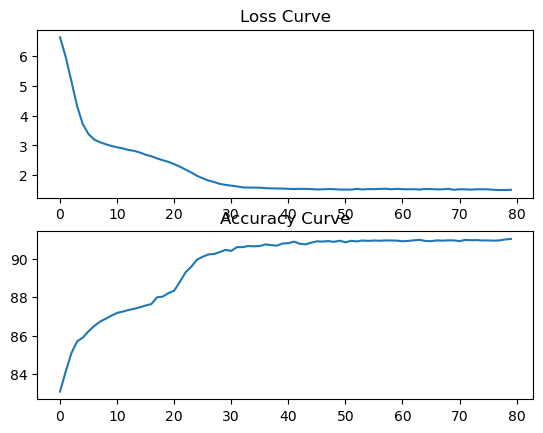

In [40]:
def train(model, trainloader, testloader, criterion, optimizer, epochs=10 ):
    acc_curve = []
    loss_curve = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in tqdm(enumerate(trainloader), desc="Training"):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i %10 == 9:
                acc = test(model, testloader)
                print(f"Epoch: {epoch+1}, Batch: {i+1}, Loss: {running_loss/10}, Accuracy: {acc} ")
                acc_curve.append(acc)
                loss_curve.append(running_loss)
                running_loss = 0.0
                # test

    print('Finished Training')
    return acc_curve, loss_curve
        
model = Classifier()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = model.to(device)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

acc_curve, loss_curve = train(model, trainloader, testloader, criterion, optimizer, epochs=10)
plt.subplot(2,1,1)
plt.title("Loss Curve")
plt.plot(loss_curve)
plt.subplot(2,1,2)
plt.title("Accuracy Curve")
plt.plot(acc_curve)
plt.show()

In [46]:
model = Classifier()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = model.to(device)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

acc_curve, loss_curve = train(model, trainloader, testloader, criterion, optimizer, epochs=5)
plt.subplot(2,1,1)
plt.title("Loss Curve")
plt.plot(loss_curve)
plt.subplot(2,1,2)
plt.title("Accuracy Curve")
plt.plot(acc_curve)
plt.show()

Let's use 4 GPUs!


Training: 0it [00:01, ?it/s]


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home2/anirudhkaushik/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/home2/anirudhkaushik/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/ipykernel_4641/3276073437.py", line 11, in forward
    x = F.relu(self.fc1(x))
  File "/home2/anirudhkaushik/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home2/anirudhkaushik/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/linear.py", line 114, in forward
    return F.linear(input, self.weight, self.bias)
RuntimeError: mat1 and mat2 shapes cannot be multiplied (8192x16 and 17x64)
